In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import bs4 as bs
import requests
import datetime as dt
from datetime import datetime, timedelta
import time
import timeit
import os
import pandas_datareader.data as pdr
from math import sqrt
import operator
from functools import reduce
import joblib
import pickle

from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from catboost import CatBoostRegressor
from catboost import Pool, cv

In [2]:
%matplotlib inline

In [3]:
# !pip install pmdarima
# !pip install yfinance
# !pip install optuna
# !pip install catboost

In [4]:
import optuna
import yfinance as yf

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/parser_yf.py
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/preprocessing.py
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/feature_engineering.py
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/ts_features.py  
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/LSTM_ts_loaders.py

In [7]:
from preprocessing import data_preprocessing 
from feature_engineering import feature_engineering
from ts_features import ts_features

### Data preprocessing and Feature engineering 

snp = yf.download('%5EGSPC', start='2010-01-01', end='2023-03-31')
snp.columns = snp.columns.str.lower()

In [8]:
df = pd.read_csv('sp500_raw.csv', parse_dates=['date'])

In [9]:
%%time

categorical_cols = ['symbol', 'gics sector', 'gics sub-industry']
dff = data_preprocessing(df).preprocessing_steps()

fe = feature_engineering(dff, cat_features=categorical_cols)
dff = fe.get_data()
enc_dict = fe.get_enc_dict()

dff = ts_features(dff, y='adj close_norm', lag_orders=[7,8,9,10,11,12,13], ma_windows=[7]).add_features()

CPU times: user 1min 27s, sys: 656 ms, total: 1min 28s
Wall time: 1min 28s


In [10]:
dff.head(3)

,date,open,high,low,close,adj close,volume,symbol,gics sector,gics sub-industry,...,adj close_norm,lag_7_adj close_norm,lag_8_adj close_norm,lag_9_adj close_norm,lag_10_adj close_norm,lag_11_adj close_norm,lag_12_adj close_norm,lag_13_adj close_norm,ma_7_adj close_norm,ma_7_lag_adj close_norm
0,2013-02-01,31.50,31.74,30.469999,31.010000,28.823187,66789100,502,5,98,...,0.004720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004720,0.0
1,2013-02-04,31.09,31.99,30.760000,31.020000,28.832491,7695400,502,5,98,...,0.004721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004721,0.0
2,2013-02-05,31.25,31.98,30.850000,31.040001,28.851086,5013200,502,5,98,...,0.004724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004722,0.0


### Experiments

In [11]:
def evaluate_res(predictions, actual) -> dict:
    '''Calculate metrics'''
    metrics_dict = {}
    metrics_dict['RMSE'] = round(sqrt(mean_squared_error(actual, predictions)), 3)
    metrics_dict['MAE'] = round(mean_absolute_error(actual, predictions), 3)
    metrics_dict['MAPE'] = round(mean_absolute_percentage_error(actual, predictions), 3)
    return metrics_dict

In [33]:
days = ['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09']
days2 = ['2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20']

### RF experiments

**All tickers**

In [13]:
def training_rf(X_train, y_train, X_test, y_test, days, params=None):
    """Training and evaluting RF"""
    if params is None:
        params = {'n_estimators': 100, 'random_state': 42}
    
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    rescaled_pred = enc_dict['scaler'].inverse_transform(pred.reshape(1, -1))[0]
    
    # total results
    res_dict = evaluate_res(rescaled_pred, y_test)
    # results for each day
    pred_act = pd.DataFrame(y_test, index=y_test.index)
    pred_act['pred'] = rescaled_pred
    results_rf = []
    for d in days:
        results_rf.append(evaluate_res(pred_act[pred_act.index <= d]['adj close'], 
                                       pred_act[pred_act.index <= d]['pred']))
    res_df = pd.DataFrame(data=results_rf, index=days).T
    
    # results by sectors
    test_df = pd.concat([pred_act, X_test], axis=1)
    test_df['gics sector'] = enc_dict['gics sector'].inverse_transform(test_df['gics sector'])
    test_df['symbol'] = enc_dict['symbol'].inverse_transform(test_df['symbol'])
    test_df['gics sub-industry'] = enc_dict['gics sub-industry'].inverse_transform(test_df['gics sub-industry'])
    results_rf_sec = []
    sectors = sorted(test_df['gics sector'].unique())
    for sec in sectors:
        a = test_df[test_df['gics sector'] == sec]
        results_rf_sec.append(evaluate_res(a['adj close'], a['pred']))
    res_sec = pd.DataFrame(data=results_rf_sec, index=sectors).sort_values(by='MAPE').T
    
    return rf, res_dict, res_df, res_sec


In [14]:
def calc_feat_imp(rf, features):
    """get table with features' importances"""
    importances = rf.feature_importances_.tolist()
    imp_tab = pd.DataFrame(data={'importance': importances}, index=features, 
                          ).sort_values(by='importance', ascending=False)

    return imp_tab 
    

In [15]:
cols = ['open', 'high', 'low', 'close', 'volume', 'ma_7_adj close_norm']
df_rf = dff.set_index(keys='date', drop=True).drop(cols, axis=1)

In [16]:
train = df_rf[:'2023-02-28']
test = df_rf['2023-03-01':'2023-03-09']

X_train = train.drop(['adj close', 'adj close_norm'], axis=1)
y_train = train['adj close_norm']
X_test = test.drop(['adj close', 'adj close_norm'], axis=1)
y_test = test['adj close']

#### Using Optuna for parameters' tuning

In [17]:
def objective(trial):
    params = {
        "random_state": 42,
        #"criterion": "absolute_error",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 10, 50)
        }

    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    pred = rf.predict(X_test)
    rescaled_pred = enc_dict['scaler'].inverse_transform(pred.reshape(1, -1))[0]
    
    return -mean_squared_error(rescaled_pred, y_test)

In [18]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=60)

[I 2023-06-09 10:54:52,104] A new study created in memory with name: no-name-a7ce10f9-8bda-49a2-b502-16b06cec4ba8
[I 2023-06-09 11:18:48,718] Trial 0 finished with value: -267.9730497477978 and parameters: {'n_estimators': 76, 'max_depth': 25}. Best is trial 0 with value: -267.9730497477978.


CPU times: user 23min 27s, sys: 5.71 s, total: 23min 32s
Wall time: 23min 56s


In [19]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1
Best trial:
  Value: -267.9730497477978
  Params: 
    n_estimators: 76
    max_depth: 25


%%time

rf_opt = RandomForestRegressor(**trial.params)
rf_opt.fit(X_train, y_train)

In [20]:
%%time

model_opt, ttl_scores_opt, week_scores_opt, sectors_scores_opt = training_rf(X_train, y_train, 
                                                                             X_test, y_test, 
                                                                             days, trial.params)

CPU times: user 23min 27s, sys: 5.52 s, total: 23min 33s
Wall time: 23min 57s


In [21]:
print(ttl_scores_opt)
display(week_scores_opt)
display(sectors_scores_opt)

{'RMSE': 14.627, 'MAE': 5.399, 'MAPE': 0.032}


,2023-03-01,2023-03-02,2023-03-03,2023-03-06,2023-03-07,2023-03-08,2023-03-09
RMSE,11.532,13.594,14.546,14.729,14.692,14.767,14.627
MAE,5.821,5.482,5.653,5.582,5.526,5.459,5.399
MAPE,0.038,0.034,0.033,0.032,0.032,0.031,0.031


,Consumer Staples,Industrials,Utilities,Financials,Real Estate,Health Care,Materials,Consumer Discretionary,Energy,Information Technology,Communication Services
RMSE,3.940,7.479,2.804,6.535,5.697,11.711,7.048,38.038,4.079,12.600,5.476
MAE,2.291,4.646,2.086,4.012,3.672,6.630,4.196,12.506,2.755,7.079,3.311
MAPE,0.022,0.027,0.028,0.030,0.031,0.032,0.032,0.033,0.034,0.037,0.044


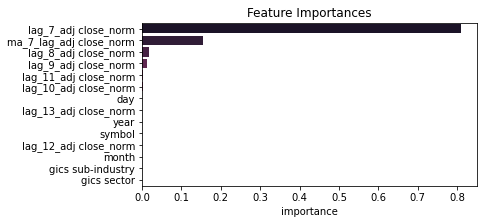

In [22]:
imp_tab = calc_feat_imp(model_opt, X_train.columns.tolist())

idx = imp_tab.index.tolist()
plt.figure(figsize=(6,3))
sns.barplot(y=idx, x=imp_tab['importance'], palette="rocket").set(title='Feature Importances')
plt.show()

#### Simple RF with lags

In [23]:
%%time

model1, ttl_scores, week_scores, sectors_scores = training_rf(X_train, y_train, X_test, y_test, days)

CPU times: user 41min 46s, sys: 14.6 s, total: 42min 1s
Wall time: 42min 51s


In [24]:
print(ttl_scores)
display(week_scores)
display(sectors_scores)

{'RMSE': 15.962, 'MAE': 5.581, 'MAPE': 0.032}


,2023-03-01,2023-03-02,2023-03-03,2023-03-06,2023-03-07,2023-03-08,2023-03-09
RMSE,12.184,14.161,15.610,15.972,16.225,16.239,15.962
MAE,5.712,5.476,5.747,5.703,5.682,5.630,5.581
MAPE,0.036,0.033,0.033,0.031,0.031,0.031,0.032


,Consumer Staples,Industrials,Utilities,Financials,Real Estate,Health Care,Materials,Consumer Discretionary,Energy,Information Technology,Communication Services
RMSE,3.694,7.497,2.804,6.369,5.684,11.973,6.826,42.667,4.113,12.894,5.939
MAE,2.176,4.660,2.057,3.969,3.540,6.628,4.180,14.069,2.853,7.272,3.538
MAPE,0.021,0.027,0.028,0.030,0.030,0.032,0.033,0.034,0.035,0.038,0.045


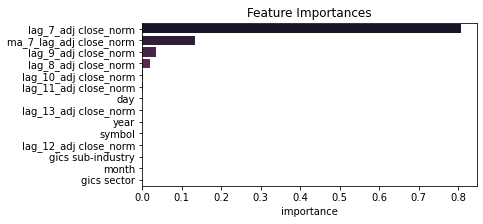

In [25]:
imp_tab = calc_feat_imp(model1, X_train.columns.tolist())

idx = imp_tab.index.tolist()
plt.figure(figsize=(6,3))
sns.barplot(y=idx, x=imp_tab['importance'], palette="rocket").set(title='Feature Importances')
plt.show()

#### Simple RF with lags for 2nd week

In [30]:
train = df_rf[:'2023-02-09']
test = df_rf['2023-03-10':'2023-03-20']

X_train = train.drop(['adj close', 'adj close_norm'], axis=1)
y_train = train['adj close_norm']
X_test = test.drop(['adj close', 'adj close_norm'], axis=1)
y_test = test['adj close']

In [34]:
%%time

model1, ttl_scores, week_scores, sectors_scores = training_rf(X_train, y_train, X_test, y_test, days2)

CPU times: user 41min 45s, sys: 16.3 s, total: 42min 1s
Wall time: 43min 20s


In [35]:
print(ttl_scores)
display(week_scores)
display(sectors_scores)

{'RMSE': 20.261, 'MAE': 8.565, 'MAPE': 0.069}


,2023-03-10,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17,2023-03-20
RMSE,19.214,17.853,17.001,16.967,17.815,19.415,20.261
MAE,7.226,7.741,7.847,8.343,8.378,8.710,8.565
MAPE,0.049,0.056,0.058,0.062,0.062,0.064,0.062


,Utilities,Consumer Staples,Health Care,Information Technology,Communication Services,Industrials,Real Estate,Consumer Discretionary,Materials,Energy,Financials
RMSE,2.091,4.686,10.978,12.685,7.532,15.395,8.343,51.412,13.615,9.129,16.128
MAE,1.545,3.184,7.578,8.192,4.318,9.388,6.387,15.283,9.947,7.222,11.893
MAPE,0.024,0.029,0.039,0.046,0.056,0.058,0.065,0.067,0.083,0.094,0.113


#### Simple RF without TS features

In [26]:
cat_cols = ['symbol', 'gics sector', 'gics sub-industry', 'year', 'month', 'day']
X_train = train.drop(['adj close', 'adj close_norm'], axis=1)[cat_cols]
y_train = train['adj close_norm']
X_test = test.drop(['adj close', 'adj close_norm'], axis=1)[cat_cols]
y_test = test['adj close']

In [27]:
%%time

model2, ttl_scores, week_scores, sectors_scores = training_rf(X_train, y_train, X_test, y_test, days)

CPU times: user 4min 44s, sys: 5.85 s, total: 4min 50s
Wall time: 5min 10s


In [28]:
print(ttl_scores)
display(week_scores)
display(sectors_scores)

{'RMSE': 23.087, 'MAE': 5.634, 'MAPE': 0.033}


,2023-03-01,2023-03-02,2023-03-03,2023-03-06,2023-03-07,2023-03-08,2023-03-09
RMSE,14.909,15.433,17.115,20.175,21.955,23.215,23.087
MAE,3.234,3.535,4.202,4.805,5.156,5.461,5.634
MAPE,0.019,0.020,0.024,0.027,0.030,0.032,0.033


,Real Estate,Consumer Staples,Communication Services,Energy,Health Care,Utilities,Information Technology,Financials,Industrials,Materials,Consumer Discretionary
RMSE,3.845,4.648,4.673,3.525,10.575,3.994,11.560,6.919,8.600,5.454,67.250
MAE,2.480,2.539,2.470,2.475,5.881,2.403,5.794,4.287,4.983,3.614,17.554
MAPE,0.022,0.024,0.028,0.029,0.029,0.030,0.032,0.034,0.035,0.036,0.055


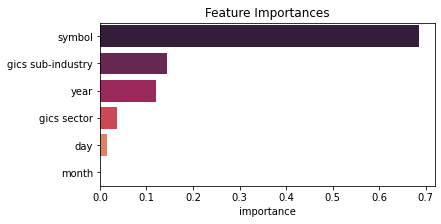

In [29]:
imp_tab = calc_feat_imp(model2, X_train.columns.tolist())

idx = imp_tab.index.tolist()
plt.figure(figsize=(6,3))
sns.barplot(y=idx, x=imp_tab['importance'], palette="rocket").set(title='Feature Importances')
plt.show()

_____________________________________________________________________________